In [1]:
# !pip install pycuda

# Медианный фильтр

## 1. Классический подход (с чем сравнивать будем)

In [1]:
import numpy as np
from PIL import Image, ImageOps
import matplotlib.pyplot as plt

In [2]:
im = Image.open("photo.jpg")

In [3]:
w, h = im.size
im = im.resize((w // 16, h // 16))  # чтобы побыстрее
im = ImageOps.grayscale(im)
im = np.asarray(im)
im = (im / 255).astype(np.float32)
im.shape, im.dtype

((250, 375), dtype('float32'))

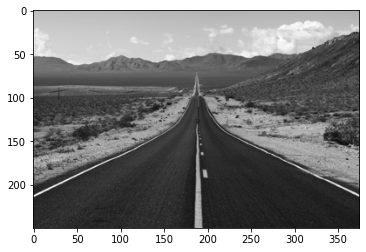

In [4]:
plt.imshow(im, cmap='gray', vmin=0, vmax=1);

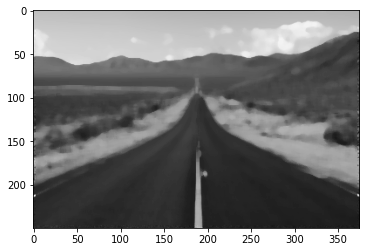

In [22]:
median_filter_size = 7
imf = im.copy()

for i in range(median_filter_size // 2, im.shape[0] - median_filter_size // 2):
    for j in range(median_filter_size // 2, im.shape[1] - median_filter_size // 2):
        i1 = i - median_filter_size // 2
        i2 = i + median_filter_size // 2 + 1
        j1 = j - median_filter_size // 2
        j2 = j + median_filter_size // 2 + 1
        imf[i, j] = np.median(im[i1:i2, j1:j2])

plt.imshow(imf, cmap='gray', vmin=0, vmax=1);

## 2. Реализация через cuda

In [23]:
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule

In [24]:
# копирование исходного изображения
im_gpu = cuda.mem_alloc(im.reshape(-1).nbytes)
cuda.memcpy_htod(im_gpu, im.reshape(-1))
# отфильтрованное изображение
imf_gpu = cuda.mem_alloc(im.reshape(-1).nbytes)
cuda.memcpy_htod(imf_gpu, im.reshape(-1))
# копирование размера фильтра
fs_gpu = cuda.mem_alloc(np.array(median_filter_size).nbytes)
cuda.memcpy_htod(fs_gpu, np.array(median_filter_size))
# копирование ширины и высоты картинки
w_gpu = cuda.mem_alloc(np.array(im.shape[1]).nbytes)
cuda.memcpy_htod(w_gpu, np.array(im.shape[1]))
h_gpu = cuda.mem_alloc(np.array(im.shape[0]).nbytes)
cuda.memcpy_htod(h_gpu, np.array(im.shape[0]))

/usr/local/lib/python3.8/dist-packages/google/colab/_variable_inspector.py:27: UserWarning: device_allocation in out-of-thread context could not be cleaned up
  globals().clear()


In [30]:
mod = SourceModule("""

  __device__ unsigned int getGlobalIdx()
  {
      // глобальный индекс 
      unsigned int innerIdx = threadIdx.x + threadIdx.y * blockDim.x + threadIdx.z * blockDim.x * blockDim.y;
      unsigned int globalIdx = (blockIdx.x + blockIdx.y * gridDim.x + blockIdx.z * gridDim.x * gridDim.y) 
                              * blockDim.x * blockDim.y * blockDim.z 
                              + innerIdx;

      return globalIdx;
  }

  __global__ void MedianFilter(float * im, float * imf, int * fs, int * w, int * h)
  {
    unsigned int globalIdx = getGlobalIdx();

    int k, l, i, j;

    float * localImg;
    float tmp;
    localImg = (float *) malloc(fs[0] * fs[0] * sizeof(float));

    j = -1;
    for (k = -fs[0] / 2; k < fs[0] / 2 + 1; k++)
    {
      for (l = -fs[0] / 2; l < fs[0] / 2 + 1; l++)
      {
        i = globalIdx + k * w[0] + l;
        if (i < 0 || i >= h[0] * w[0]) {
          break;
        }
        j++;
        localImg[j] = im[i];
      }
    }

    if (j == fs[0] * fs[0] - 1) {
      for(i = 0; i < fs[0] * fs[0] - 1; i++) { 
        for(j = 0; j < fs[0] * fs[0] - i - 1 ; j++) {  
            if (localImg[j] > localImg[j + 1]) {           
                tmp = localImg[j];
                localImg[j] = localImg[j + 1];
                localImg[j + 1] = tmp; 
            }
          }
      }

      imf[globalIdx] = localImg[fs[0] * fs[0] / 2];
    }

    free(localImg);
  }

  """
)

In [31]:
func = mod.get_function("MedianFilter")

func(
    im_gpu, imf_gpu, fs_gpu, w_gpu, h_gpu,
    block=(16, 16, 1), grid=(64, 64)
)


/usr/local/lib/python3.8/dist-packages/google/colab/_variable_inspector.py:27: UserWarning: module in out-of-thread context could not be cleaned up
  globals().clear()


In [32]:
# копирование на ЦПУ
imf_cpu = np.empty_like(im.reshape(-1))
cuda.memcpy_dtoh(imf_cpu, imf_gpu)
imf_cpu = imf_cpu.reshape(im.shape)


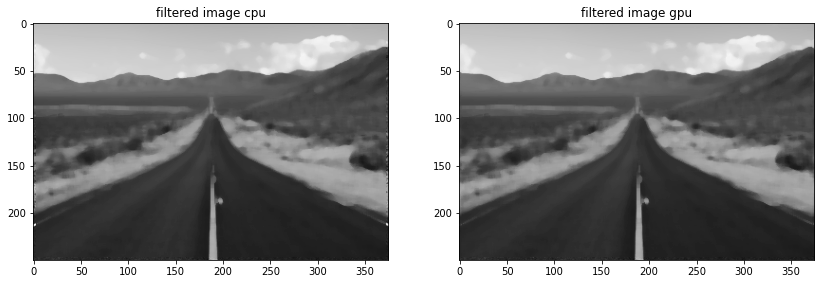

In [33]:
plt.figure(figsize=(14, 5))
plt.subplot("121")
plt.imshow(imf, cmap='gray', vmin=0, vmax=1);
plt.title('filtered image cpu')
plt.subplot("122")
plt.imshow(imf_cpu, cmap='gray', vmin=0, vmax=1);
plt.title('filtered image gpu');